In [101]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

import random

In [102]:
batch_size = 8192
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# Transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

cuda


In [103]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 30
beta = 0.95

In [104]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_outputs, bias=False)
        self.lif1 = snn.Leaky(beta=beta)
    def forward(self, x):
        mem1 = self.lif1.init_leaky()

        spk1_rec = []
        mem1_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0)
        
net = Net().to(device)

In [105]:
state_dict = net.state_dict()

In [106]:
loss = nn.CrossEntropyLoss()

In [107]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spk_rec, mem_rec = net(data.view(batch_size, -1))
print(data.size())

torch.Size([8192, 1, 28, 28])


In [108]:
def fitness_function(chromosome_input, parameter_input):
    
    state_dict = net.state_dict()
    state_dict[parameter_input] = chromosome_input.clone().detach()
    net.load_state_dict(state_dict)

    '''data, targets = next(iter(train_loader))
    data = data.to(device)
    targets = targets.to(device)'''

    spk_rec, mem_rec = net(data.view(batch_size, -1))

    # initialize the total loss value
    loss_val = torch.zeros((1), dtype=dtype, device=device)

    # sum loss at every step
    for step in range(num_steps):
        loss_val += loss(mem_rec[step], targets)

    training_loss = loss_val.item()

    return training_loss

In [109]:
'''def fitness_function(chromosome_input, parameter_input):

    #print(chromosome)
    data, targets = next(iter(train_loader))
    data = data.to(device)
    targets = targets.to(device)

    state_dict[parameter_input] = chromosome_input.clone().detach()
    #state_dict[parameter_hidden] = chromosome_hidden.clone().detach()
    net.load_state_dict(state_dict)
    
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    return acc*100'''

'def fitness_function(chromosome_input, parameter_input):\n\n    #print(chromosome)\n    data, targets = next(iter(train_loader))\n    data = data.to(device)\n    targets = targets.to(device)\n\n    state_dict[parameter_input] = chromosome_input.clone().detach()\n    #state_dict[parameter_hidden] = chromosome_hidden.clone().detach()\n    net.load_state_dict(state_dict)\n    \n    output, _ = net(data.view(batch_size, -1))\n    _, idx = output.sum(dim=0).max(1)\n    acc = np.mean((targets == idx).detach().cpu().numpy())\n\n    return acc*100'

In [110]:
def crossover(population, row, column):

    for i in range(2, int(population_number/2)+1, 2):        
        children = torch.zeros(2,row,column, device=device)
        crossover_col = torch.randint(0,column,(1,))

        for n in range(2):
            children[n,:,:crossover_col], children[n,:,crossover_col:] = population[i-2,:,:crossover_col], population[i-1,:,crossover_col:]

        population = torch.cat((population,children))
    return population

In [111]:
'''def selection(population, row, column):

    population_temp = population.clone().detach()

    for i in range(int(population_number/4)):
        
        parents = torch.zeros(2, row, column, device=device)
        children = torch.zeros(2, row,column, device=device)

        

        for n in range(2):
            
            selection_length = population_temp.size()[0]
            parent_num = random.choice(range(selection_length))
            parents[n,:,:] = population_temp[parent_num,:,:]
            population_temp = torch.cat((population_temp[:parent_num], population_temp[parent_num+1:]))

        for n in range(2):
            
            for row_count in range(row):
                    for column_count in range(column):
                        if random.random() < 1:
                            children[n, row_count, column_count] = parents[random.randint(0,1),row_count,column_count]
                        else:
                            children[n, row_count, column_count] = random.random()
        
        
        population = torch.cat((population,children))
    return population'''

'def selection(population, row, column):\n\n    population_temp = population.clone().detach()\n\n    for i in range(int(population_number/4)):\n        \n        parents = torch.zeros(2, row, column, device=device)\n        children = torch.zeros(2, row,column, device=device)\n\n        \n\n        for n in range(2):\n            \n            selection_length = population_temp.size()[0]\n            parent_num = random.choice(range(selection_length))\n            parents[n,:,:] = population_temp[parent_num,:,:]\n            population_temp = torch.cat((population_temp[:parent_num], population_temp[parent_num+1:]))\n\n        for n in range(2):\n            \n            for row_count in range(row):\n                    for column_count in range(column):\n                        if random.random() < 1:\n                            children[n, row_count, column_count] = parents[random.randint(0,1),row_count,column_count]\n                        else:\n                            childr

In [112]:
def mutation_backprop(input, hidden, mutation_prob, parameter_input, parameter_hidden, best_chromosomes, best_loss_index):

    for i in range(population_number):

        if not (random.random() < mutation_prob):
            continue
        state_dict = net.state_dict()
        state_dict[parameter_input] = input[i,:,:].clone().detach()
        state_dict[parameter_hidden] = hidden[i,:,:].clone().detach()
        net.load_state_dict(state_dict)
        
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the total loss value
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # sum loss at every step
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # clear previously stored gradients
        optimizer.zero_grad()

        # calculate the gradients
        loss_val.backward()

        # weight update
        optimizer.step()

        state_dict = net.state_dict()
        
        input[i,:,:] = state_dict[parameter_input]
        hidden[i,:,:] = state_dict[parameter_hidden]
    
    return input, hidden 


In [113]:
def mutation(population, best_chromosome, population_number, row, column, best_prob):
    mutation_prob = 1
    for i in range(0, int(population_number)):
        if random.random() < best_prob:
            for row_count in range(row):
                for column_count in range(column):
                    if random.random() < 0.0003:
                        if random.random() < 0.5:
                            population[i, row_count, column_count] += random.random()*0.5
                        else:
                            population[i, row_count, column_count] -= random.random()*0.5
        else:
            population[i,:,:] = best_chromosome[:,:]
    return population


In [114]:
def evolve(input, population_number, parameter_input):

    input_row = input.size()[1]
    input_column = input.size()[2]

    test_accuracy_hist= []
    loss_hist = []

    solution_input = torch.zeros(generation_goal, input_row, input_column, device=device)
    best_acc = 99999
    best_loss_index = 0
    best_prob = .98

    for evolution_number in range(generation_goal):
        
        best_acc_gen = 99999
        accuracy_generation_list = torch.full((2,int(population_number/2)), 99999)
        temp_input = torch.zeros(int(population_number/2), input_row, input_column, device=device)

        for chromosome_number in range(population_number):

            accuracy = fitness_function(input[chromosome_number,:,:], parameter_input)
                  
            if accuracy < best_acc:
                best_acc = accuracy
                best_loss_index = evolution_number

            if accuracy < best_acc_gen:
                best_acc_gen = accuracy
                solution_input[evolution_number,:,:] = input[chromosome_number,:,:].detach().clone()
                
            highest_loss_index = torch.max(accuracy_generation_list, 1)         
            
            if (accuracy) < highest_loss_index[0][1]:

                indice = int(highest_loss_index[1][1])
                accuracy_generation_list[0][indice] = chromosome_number
                accuracy_generation_list[1][indice] = accuracy

        temp_input = torch.zeros((int(population_number/2), input_row, input_column), device=device)

        loss_hist.append(best_acc)
        
        try:
            if best_acc_gen > loss_hist[evolution_number - 1]:
                best_prob = .9
        except:
            pass

        for n in range(int(population_number/2)):
            index = torch.min(accuracy_generation_list,1)
            temp_input[n,:,:] = input[index[1][1],:,:]
            accuracy_generation_list[1][index[1][1]] = 99999
        
        if (evolution_number % 500) == 0:
            state_dict = net.state_dict()
            state_dict[parameter_input] = solution_input[best_loss_index, :, :]
            net.load_state_dict(state_dict)
            accuracy_test = test_acc()
            test_accuracy_hist.append(accuracy_test)

            print(f"""
            Generation:         {evolution_number}/{generation_goal}
            Training loss:      {best_acc:.2f}
            Test accuracy:      {accuracy_test:.2f}%\n"""
            )

            data, targets = next(iter(train_loader))
            data = data.to(device)
            targets = targets.to(device)

            best_acc = 99999          

        temp_input = crossover(temp_input, input_row, input_column)
        temp_input = mutation(temp_input, solution_input[best_loss_index,:,:], population_number, input_row, input_column, best_prob)

        input = temp_input.detach().clone()

           

    state_dict = net.state_dict()
    state_dict[parameter_input] = solution_input[generation_goal-1].detach().clone()
    net.load_state_dict(state_dict)
    
    return solution_input, loss_hist 
            

In [115]:
def test_acc():
  total = 0
  correct = 0

  test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

  with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
      data = data.to(device)
      targets = targets.to(device)
      
      # forward pass
      test_spk, _ = net(data.view(data.size(0), -1))

      # calculate total accuracy
      _, predicted = test_spk.sum(dim=0).max(1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

  
  return (100 * correct / total)

In [116]:
population_number = 8
generation_goal = 10000
mutation_prob = 0.1

In [117]:
with torch.no_grad():
    net.eval()

    fc1w = torch.randn(population_number, num_outputs, num_inputs, device=device)
    mul = torch.tensor([0.01], device=device)
    fc1w = torch.multiply(fc1w, mul)

    input, loss_hist = evolve(fc1w, population_number, 'fc1.weight')

test_acc()


            Generation:         0/10000
            Training loss:      71.78
            Test accuracy:      11.70%


            Generation:         500/10000
            Training loss:      48.84
            Test accuracy:      46.99%


            Generation:         1000/10000
            Training loss:      43.07
            Test accuracy:      56.04%


            Generation:         1500/10000
            Training loss:      35.98
            Test accuracy:      66.33%


            Generation:         2000/10000
            Training loss:      32.44
            Test accuracy:      69.13%


            Generation:         2500/10000
            Training loss:      29.93
            Test accuracy:      72.17%


            Generation:         3000/10000
            Training loss:      28.13
            Test accuracy:      74.23%


            Generation:         3500/10000
            Training loss:      26.46
            Test accuracy:      76.03%


            Generation:    

81.94

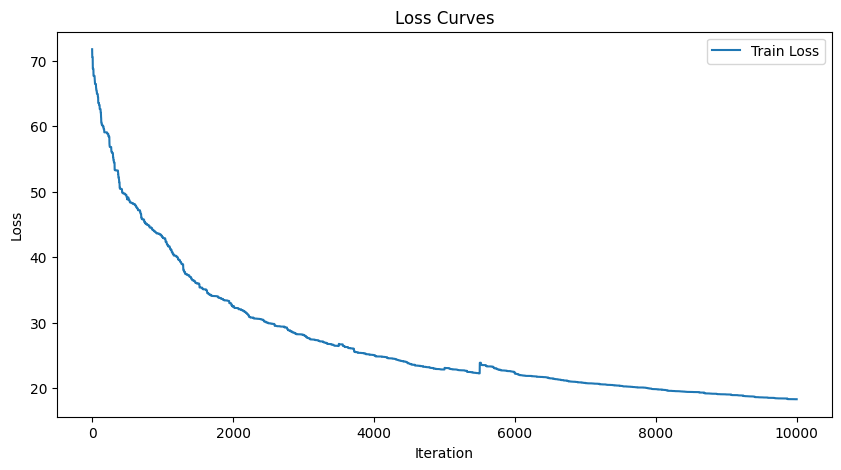

In [118]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()